In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
from collections import Counter
import joblib
# Métodos de Validación
from sklearn.model_selection import train_test_split

# Modelos de Clasificación
from category_encoders import *
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split


from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Métricas para Clasificación
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# OverSampling y UnderSampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [27]:
df = pd.read_pickle(r'C:\Users\Nahuel\Documents\hack_a_boss\mod7-streamlit-main\proyecto_aviones\data\pickle\vuelos_limpio.pkl')

In [28]:
# Creamos la columna target y ya la binarizamos
df["llega_tarde"] = np.where(df['retraso_llegada'] > 15, 'si', 'no')
df['llega_tarde'] = df['llega_tarde'].map({'si': 1, 'no': 0})

In [29]:
# Eliminamos las columnas que no aportan información extra y retraso en la llegada para que no prediga el 100% de las veces y mes que solo tiene 1 valor
columnas_eliminar = [
    "latitude_destino",
    "latitude_origen",
    "longitude_destino",
    "longitude_origen",
    "codigo_aeropuerto_destino",
    "codigo_aeropuerto_origen",
    "direccion_destino",
    "direccion_origen",
    "retraso_llegada",
    "hora_llegada_real",
    "mes",
    'retraso_salida',
    'tiempo_retraso_aerolinea',
    'tiempo_retraso_sistema_aviacion',
    'hora_salida_real', 
    'hora_despegue', 
    'tiempo_pista_salida', 
    'duracion_real',
    'tiempo_retraso_clima',
    'festivos',
    'tiempo_retraso_seguridad',
    "duracion_programada_vuelo",
    "distancia_millas",
    "fin_de_semana",
    "numero_vuelo",
    "anio"]

df.drop(columns=columnas_eliminar, inplace=True)

In [30]:
df

,aerolinea,fecha,numero_cola,hora_salida_programada,ciudad_origen,estado_origen,aeropuerto_origen,dia_semana,ciudad_destino,estado_destino,aeropuerto_destino,llega_tarde
0,Envoy Air,2021-12-01,N202NN,08:11:00,Abilene,TX,Abilene Regional,2,Dallas/Fort Worth,TX,Dallas/Fort Worth International,0
1,Envoy Air,2021-12-01,N653AE,06:45:00,Abilene,TX,Abilene Regional,2,Dallas/Fort Worth,TX,Dallas/Fort Worth International,0
2,Envoy Air,2021-12-01,N616AE,14:47:00,Abilene,TX,Abilene Regional,2,Dallas/Fort Worth,TX,Dallas/Fort Worth International,0
3,Envoy Air,2021-12-01,N681AE,12:35:00,Abilene,TX,Abilene Regional,2,Dallas/Fort Worth,TX,Dallas/Fort Worth International,0
4,Envoy Air,2021-12-01,N687JS,18:36:00,Abilene,TX,Abilene Regional,2,Dallas/Fort Worth,TX,Dallas/Fort Worth International,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1692471,SkyWest Airlines,2023-12-30,N641CA,16:28:00,Aberdeen,SD,Aberdeen Regional,5,Minneapolis,MN,Minneapolis-St Paul International,0
1692472,SkyWest Airlines,2021-12-31,N931EV,17:31:00,Aberdeen,SD,Aberdeen Regional,4,Minneapolis,MN,Minneapolis-St Paul International,0
1692473,SkyWest Airlines,2021-12-31,N873AS,05:35:00,Aberdeen,SD,Aberdeen Regional,4,Minneapolis,MN,Minneapolis-St Paul International,0
1692474,SkyWest Airlines,2022-12-31,N922EV,07:00:00,Aberdeen,SD,Aberdeen Regional,5,Minneapolis,MN,Minneapolis-St Paul International,0


In [6]:
# Cambiamos a minutos las columnas horarias
df["hora_salida_programada"] = df["hora_salida_programada"].apply(lambda x: x.hour * 60 + x.minute)

In [7]:
# Como da error el datetime de fecha, extraemos el día del mes, que es el único que nos falta, porque mes como todos tienen el mismo no hace falta
# y sobbreescribimos la columna de fecha, 

df['fecha'] = df['fecha'].dt.day

In [8]:
# Miramos las columnas object que tenemos que cambiar a numéricas para el modelo
columnas_categoricas = df.select_dtypes(include=["object"]).columns.tolist()
columnas_categoricas

['aerolinea',
 'numero_cola',
 'ciudad_origen',
 'estado_origen',
 'aeropuerto_origen',
 'ciudad_destino',
 'estado_destino',
 'aeropuerto_destino']

Target Encoding o mean encoding: Reemplaza cada valor de la variable categórica con una estadística calculada a partir de la variable objetivo. 
- Es útil para variables categóricas con alta cardinalidad, pero puede causar overfitting si no se maneja adecuadamente. En casos de alta cardinalidad, el uso de codificaciones como one-hot encoding puede generar un gran número de columnas, lo que puede aumentar significativamente la dimensionalidad de los datos y hacer que los modelos sean más difíciles de entrenar y menos interpretables.

In [9]:
df_original = df.copy()

In [10]:
def target_encoding(df, columna_categorica, target):
    media_columna_con_target = df.groupby(columna_categorica)[target].mean()
    df[columna_categorica] = df[columna_categorica].map(media_columna_con_target)
    return media_columna_con_target

mean_map_aerolinea = target_encoding(df, 'aerolinea', 'llega_tarde')
mean_map_numero_cola = target_encoding(df, 'numero_cola', 'llega_tarde')
mean_map_ciudad_origen = target_encoding(df, 'ciudad_origen', 'llega_tarde')
mean_map_estado_origen = target_encoding(df, 'estado_origen', 'llega_tarde')
mean_map_aeropuerto_origen = target_encoding(df, 'aeropuerto_origen', 'llega_tarde')
mean_map_ciudad_destino = target_encoding(df, 'ciudad_destino', 'llega_tarde')
mean_map_estado_destino = target_encoding(df, 'estado_destino', 'llega_tarde')
mean_map_aeropuerto_destino = target_encoding(df, 'aeropuerto_destino', 'llega_tarde')


Estos diccionarios serán necesarios a la hora de inputar datos externo al modelo de predección (para Streamlit).

In [11]:
# Crear el diccionario de mapeo
mapeo_aerolinea         = dict(zip(df_original['aerolinea'], df['aerolinea']))
mapeo_numero_cola       = dict(zip(df_original['numero_cola'], df['numero_cola']))
mapeo_ciudad_origen     = dict(zip(df_original['ciudad_origen'], df['ciudad_origen']))
mapeo_estado_origen     = dict(zip(df_original['estado_origen'], df['estado_origen']))
mapeo_aeropuerto_origen = dict(zip(df_original['aeropuerto_origen'], df['aeropuerto_origen']))
mapeo_ciudad_origen     = dict(zip(df_original['ciudad_destino'], df['ciudad_destino']))
mapeo_estado_origen     = dict(zip(df_original['estado_destino'], df['estado_destino']))
mapeo_aeropuerto_origen = dict(zip(df_original['aeropuerto_destino'], df['aeropuerto_destino']))

In [12]:
# Aquí simplemente catalogamos las columnas para tener más clara la estrategia de tratamiento de los datos.

variables_discretas = ['aerolinea', 'fecha', 'numero_vuelo', 'numero_cola', 'hora_salida_programada', 'hora_salida_real', 'hora_despegue', 'ciudad_origen', 'estado_origen',
                       'aeropuerto_origen', 'hora_llegada_real', 'dia_semana', 'anio', 'fin_de_semana', 'festivos', 'ciudad_destino', 'estado_destino', 'aeropuerto_destino',
                       'llega_tarde']

variables_continuas = ['duracion_programada_vuelo', 'duracion_real', 'retraso_salida', 'tiempo_pista_salida', 'tiempo_retraso_aerolinea', 'tiempo_retraso_clima', 'tiempo_retraso_sistema_aviacion',
                       'tiempo_retraso_seguridad', 'distancia_millas']

Trás unas cuantas comprobaciones en los modelos, observamos que las métricas eran mejor cuando `distancia_millas` era la única varibale continua a la que debíamos aplicar logaritmo.

Aunque en principio pensamos en aplicar quartiles para eliminar valores *outliers*, los resultados de las métricas eran un poco peores, por lo que decidimos no aplicarlos.

In [13]:
df

,aerolinea,fecha,numero_cola,hora_salida_programada,ciudad_origen,estado_origen,aeropuerto_origen,dia_semana,ciudad_destino,estado_destino,aeropuerto_destino,llega_tarde
0,0.07,1,0.10,491,0.05,0.08,0.05,2,0.08,0.08,0.08,0
1,0.07,1,0.05,405,0.05,0.08,0.05,2,0.08,0.08,0.08,0
2,0.07,1,0.05,887,0.05,0.08,0.05,2,0.08,0.08,0.08,0
3,0.07,1,0.03,755,0.05,0.08,0.05,2,0.08,0.08,0.08,0
4,0.07,1,0.07,1116,0.05,0.08,0.05,2,0.08,0.08,0.08,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1692471,0.04,30,0.00,988,0.00,0.06,0.00,5,0.05,0.05,0.05,0
1692472,0.04,31,0.00,1051,0.00,0.06,0.00,4,0.05,0.05,0.05,0
1692473,0.04,31,0.00,335,0.00,0.06,0.00,4,0.05,0.05,0.05,0
1692474,0.04,31,0.00,420,0.00,0.06,0.00,5,0.05,0.05,0.05,0


In [46]:
# Definimos la target

TARGET = "llega_tarde"
X = df.drop(columns = TARGET)
y  = df[[TARGET]]

In [47]:
# Definimos train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (1353980, 11), y_train: (1353980, 1)
X_test: (338496, 11), y_test: (338496, 1)


In [48]:
# Analizamos la distribución de clases en el conjunto de datos. 

contador_clases= Counter([arr[0] for arr in list(y_train.values)])
print(contador_clases)

total = sum(contador_clases.values())
for clase, count in contador_clases.items():
    porcentaje = (count / total) * 100
    print(f'Porcentaje de "{clase}": {porcentaje:.2f}%')

Counter({0: 1248772, 1: 105208})
Porcentaje de "0": 92.23%
Porcentaje de "1": 7.77%


### Se necesita balancear las clases porque están desbalanceadas con la técnica SMOTE (Synthetic Minority Oversampling Technique).
### Vamos a hacerlo híbrido, combinando oversampling y undersampling.

In [49]:
# Definir las estrategias de balanceo
undersampling = RandomUnderSampler(sampling_strategy=0.1)
oversampling = SMOTE(sampling_strategy=0.6)

# Definir la pipeline
balance_pipeline = Pipeline([
    ('undersampling', undersampling),
    ('oversampling', oversampling)
])

# Aplicar la pipeline al conjunto de entrenamiento
X_balanceado, y_balanceado = balance_pipeline.fit_resample(X_train, y_train)

In [51]:
# Comprobamos que se han balanceado más 
contador_clases= Counter([arr[0] for arr in list(y_balanceado.values)])
print(contador_clases)

total = sum(contador_clases.values())
for clase, count in contador_clases.items():
    porcentaje = (count / total) * 100
    print(f'Porcentaje de "{clase}": {porcentaje:.2f}%')

Counter({0: 1052080, 1: 631248})
Porcentaje de "0": 62.50%
Porcentaje de "1": 37.50%


In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Definimos los parámetros que queremos probar en el grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instanciamos el modelo de árbol de decisión
tree_clf = DecisionTreeClassifier()

# Creamos un objeto GridSearchCV
grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

# Ejecutamos el grid search en los datos de entrenamiento
grid_search.fit(X_balanceado, y_balanceado)

# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Realizamos predicciones en el conjunto de prueba con el mejor modelo encontrado
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluamos la precisión del mejor modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del mejor modelo de árbol de decisión:", accuracy)


Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10}
Precisión del mejor modelo de árbol de decisión: 0.9001908442049537


In [73]:
from sklearn.tree import DecisionTreeClassifier

# Instanciamos el modelo de árbol de decisión
model = DecisionTreeClassifier(criterion = 'gini', max_depth = 20, min_samples_leaf = 2, min_samples_split =10)

# Entrenamos el modelo con los datos de entrenamiento
model.fit(X_balanceado, y_balanceado)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10)

In [74]:
# Realizamos predicciones en el conjunto de prueba
yhat = model.predict(X_test)

# Evaluamos la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo de árbol de decisión:", accuracy)

Precisión del modelo de árbol de decisión: 0.9001908442049537


In [75]:
# VALORAMOS EL MODELO DE CLASIFICACIÓN CON LAS MÉTRICAS
jaccard_index = jaccard_score(y_test, yhat, average="macro")
accuracy = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat, average="macro")
recall = recall_score(y_test, yhat, average="macro")
f1_score_value = f1_score(y_test, yhat, average="macro")
roc_auc = roc_auc_score(y_test, yhat)
conf_matrix = confusion_matrix(y_test, yhat, labels=[0, 1])
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

print("Jaccard Index:", jaccard_score(y_test, yhat, average = "macro"))
print("Accuracy:"     , accuracy_score(y_test, yhat))
print("Precisión:"    , precision_score(y_test, yhat, average = "macro"))
print("Sensibilidad / Recall:" , recall_score(y_test, yhat, average = "macro"))
print("F1-score:"     , f1_score(y_test, yhat, average = "macro"))
print("ROC AUC / Área bajo la curva ROC:"  , roc_auc_score(y_test, yhat))
print("Matriz de Confusión:", conf_matrix)
print("Especificidad:", specificity)

Jaccard Index: 0.4950470156397565
Accuracy: 0.902492200794101
Precisión: 0.5867263286273993
Sensibilidad / Recall: 0.5450743942569393
F1-score: 0.5554493467412066
ROC AUC / Área bajo la curva ROC: 0.5450743942569394
Matriz de Confusión: [[302284   9910]
 [ 23096   3206]]
Especificidad: 0.9682569171732961


In [76]:
def confusion_matrix_percent(y_true, y_pred, labels=[0, 1]):
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_percent = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100, 2)
    
    return cm_percent

conf_matrix_percent = confusion_matrix_percent(y_test, yhat, labels=[0, 1])
print(conf_matrix_percent)

[[96.83  3.17]
 [87.81 12.19]]


In [77]:
data = {'metric': ['Jaccard Index', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC', 'Specificity'],
        'value': [jaccard_index, accuracy, precision, recall, f1_score_value, roc_auc, specificity]}
df_metricas = pd.DataFrame(data)

In [78]:
df_metricas

,metric,value
0,Jaccard Index,0.50
1,Accuracy,0.90
2,Precision,0.59
3,Recall,0.55
4,F1-score,0.56
5,ROC AUC,0.55
6,Specificity,0.97


In [79]:
print(classification_report(y_test, yhat, digits = 3))

              precision    recall  f1-score   support

           0      0.929     0.968     0.948    312194
           1      0.244     0.122     0.163     26302

    accuracy                          0.902    338496
   macro avg      0.587     0.545     0.555    338496
weighted avg      0.876     0.902     0.887    338496



In [80]:
joblib.dump(model, 'model_mañana.joblib', compress=9)

['model_mañana.joblib']

In [ ]:
# Cargar el modelo desde el archivo
loaded_model = joblib.load(r"C:\Users\Nahuel\Documents\hack_a_boss\mod7-streamlit-main\proyecto_aviones\cuadernos\model_nuevo.joblib")


In [ ]:
preds = loaded_model.predict(X)

------------------------------------------------------------------------------

In [ ]:
df

,aerolinea,fecha,numero_cola,hora_salida_programada,ciudad_origen,estado_origen,aeropuerto_origen,dia_semana,ciudad_destino,estado_destino,aeropuerto_destino,llega_tarde
0,0.07,1,0.10,491,0.05,0.08,0.05,2,0.08,0.08,0.08,0
1,0.07,1,0.05,405,0.05,0.08,0.05,2,0.08,0.08,0.08,0
2,0.07,1,0.05,887,0.05,0.08,0.05,2,0.08,0.08,0.08,0
3,0.07,1,0.03,755,0.05,0.08,0.05,2,0.08,0.08,0.08,0
4,0.07,1,0.07,1116,0.05,0.08,0.05,2,0.08,0.08,0.08,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1692471,0.04,30,0.00,988,0.00,0.06,0.00,5,0.05,0.05,0.05,0
1692472,0.04,31,0.00,1051,0.00,0.06,0.00,4,0.05,0.05,0.05,0
1692473,0.04,31,0.00,335,0.00,0.06,0.00,4,0.05,0.05,0.05,0
1692474,0.04,31,0.00,420,0.00,0.06,0.00,5,0.05,0.05,0.05,0


funcion para probar datos elegidos 

In [ ]:
def data_for_prediction():
    aerolinea = 0.069746
    fecha = 2
    numero_cola = 0.071090	
    hora_salida_programada = 1116
    ciudad_origen = 0.047962
    estado_origen = 0.08393
    aeropuerto_origen = 0.047962
    dia_semana = 2
    ciudad_destino = 0.079497
    estado_destino = 0.081672
    aeropuerto_destino = 0.079497
     

    return [aerolinea, fecha, numero_cola, hora_salida_programada, ciudad_origen, estado_origen, aeropuerto_origen, dia_semana, ciudad_destino, estado_destino, aeropuerto_destino]

# Ejemplo de cómo usar la función para seleccionar datos para la predicción
selected_data2 = data_for_prediction()

funcion para elegir datos al azar y probar contra el modelo

In [ ]:
def select_data_for_prediction(df):
    # Seleccionar un dato aleatorio de cada columna y guardarlos en una lista
    aerolinea = df['aerolinea'].sample().values[0]
    fecha = df['fecha'].sample().values[0]
    numero_cola = df['numero_cola'].sample().values[0]
    hora_salida_programada = df['hora_salida_programada'].sample().values[0]
    ciudad_origen = df['ciudad_origen'].sample().values[0]
    estado_origen = df['estado_origen'].sample().values[0]
    aeropuerto_origen = df['aeropuerto_origen'].sample().values[0]
    dia_semana = df['dia_semana'].sample().values[0]
    ciudad_destino = df['ciudad_destino'].sample().values[0]
    estado_destino = df['estado_destino'].sample().values[0]
    aeropuerto_destino = df['aeropuerto_destino'].sample().values[0]
    selected_data = [aerolinea, fecha, numero_cola, hora_salida_programada, ciudad_origen, estado_origen, aeropuerto_origen, dia_semana, ciudad_destino, estado_destino, aeropuerto_destino]
    selected_data = np.array(selected_data).reshape(1, -1)
    # Devolver los datos seleccionados como una lista
    return selected_data
# Ejemplo de cómo usar la función para seleccionar datos para la predicción
selected_data = select_data_for_prediction(X2)

# Ahora puedes usar esta lista como entrada para tu modelo entrenado


In [ ]:
selected_data

array([[9.25590803e-02, 1.00000000e+01, 1.85185185e-02, 1.29500000e+03,
        6.69856459e-02, 3.33526495e-02, 9.66919317e-02, 4.00000000e+00,
        7.91971793e-02, 9.35903248e-02, 7.53463095e-02]])

In [ ]:
# Convertir la lista de datos seleccionados en una matriz bidimensional
selected_data = np.array(selected_data).reshape(1, -1)

In [ ]:
def predict_with_selected_data(model, selected_data):
    # Realizar la predicción utilizando los datos seleccionados
    prediction = model.predict(selected_data)
    return prediction

selected_data = np.array(selected_data).reshape(1, -1)

# Realizar la predicción con los datos seleccionados
prediction = predict_with_selected_data(model, selected_data)

# Imprimir la predicción
print("Predicción:", prediction)


Predicción: [0]


In [ ]:
# Declarar una variable para almacenar los datos seleccionados
selected_data = np.array(select_data_for_prediction(df)).reshape(1, -1)

# Bucle para realizar predicciones hasta que el resultado sea 1
resultado = 0
while resultado != 1:
    # Realizar la predicción con los datos seleccionados
    prediction = predict_with_selected_data(model, selected_data)
    
    # Actualizar el resultado de la predicción
    resultado = prediction
    
    # Imprimir la predicción
    print("Predicción:", prediction)
    
    # Actualizar los datos seleccionados para la próxima predicción
    selected_data = np.array(select_data_for_prediction(df)).reshape(1, -1)

# Al final del bucle, selected_data contendrá los últimos datos seleccionados


Predicción: [1]


In [ ]:
# Suponiendo que selected_data era originalmente una lista con los valores dados
original_data = selected_data.reshape(-1).tolist()


In [ ]:
original_data

[0.0796873988738593,
 7.0,
 0.12595419847328243,
 1260.0,
 0.043642241379310345,
 0.07536616307231,
 0.09257116408238833,
 3.0,
 0.0926076360682372,
 0.09359032483366213,
 0.07949736404997472]

In [ ]:
df

,aerolinea,fecha,numero_cola,hora_salida_programada,ciudad_origen,estado_origen,aeropuerto_origen,dia_semana,ciudad_destino,estado_destino,aeropuerto_destino,llega_tarde
0,0.07,1,0.10,491,0.05,0.08,0.05,2,0.08,0.08,0.08,0
1,0.07,1,0.05,405,0.05,0.08,0.05,2,0.08,0.08,0.08,0
2,0.07,1,0.05,887,0.05,0.08,0.05,2,0.08,0.08,0.08,0
3,0.07,1,0.03,755,0.05,0.08,0.05,2,0.08,0.08,0.08,0
4,0.07,1,0.07,1116,0.05,0.08,0.05,2,0.08,0.08,0.08,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1692471,0.04,30,0.00,988,0.00,0.06,0.00,5,0.05,0.05,0.05,0
1692472,0.04,31,0.00,1051,0.00,0.06,0.00,4,0.05,0.05,0.05,0
1692473,0.04,31,0.00,335,0.00,0.06,0.00,4,0.05,0.05,0.05,0
1692474,0.04,31,0.00,420,0.00,0.06,0.00,5,0.05,0.05,0.05,0


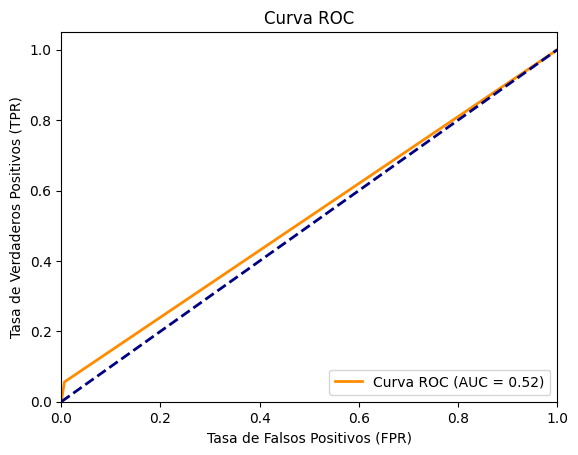

In [ ]:
from sklearn.metrics import roc_curve, auc
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, yhat)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Crear la gráfica
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()